# Training Set

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.externals import joblib
%matplotlib inline

### Read raw training data

In [2]:
amazon = pd.read_csv('/Users/andrewlevinson/programs/parsons/spring-2019/machine-learning-class/machine-learning/assignment-1/data/raw_data_train.csv')
print(amazon.shape)

(364000, 14)


In [3]:
print(amazon.head())
print(amazon['helpful'].mean())

   Unnamed: 0  Unnamed: 0.1      Id   ProductId          UserId  \
0      355714         40685   40686  B004WYLFG8  A2PAVPEC39NA9Y   
1      233345        207298  207299  B003D4IYSU   A93V92CWURUP7   
2      101305        406936  406937  B0030F70HI   AR0CBVTO8Q142   
3       53358        306295  306296  B0000VZ0G8  A3D3UHFNSO5ISQ   
4      399462        199802  199803  B002BG38R8  A2V82V20LFSWD7   

        ProfileName  HelpfulnessNumerator  HelpfulnessDenominator  Score  \
0  James E. Stewart                     0                       0      5   
1     savannah_jess                     0                       0      5   
2         scribners                     1                       3      1   
3         Subtitles                     0                       0      4   
4               J A                     0                       0      5   

         Time                        Summary  \
0  1346630400             Great Mocha Powder   
1  1333324800             Great Berry Flavor

### Feature extraction on natural language data

In [5]:
# # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
# from sklearn.feature_extraction.text import CountVectorizer
# vectorizer = CountVectorizer()
# corpus = amazon.Text.as_matrix()
# X_bag_of_words = vectorizer.fit_transform(corpus)
# print(X_bag_of_words.toarray())

In [4]:
# vectorize Bag of Words from review text; as sparse matrix
from sklearn.feature_extraction.text import HashingVectorizer
hv = HashingVectorizer(n_features=2 ** 17, non_negative=True)
X_hv = hv.fit_transform(amazon.Text)
print(X_hv.shape)

/Users/andrewlevinson/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/hashing.py:102: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
/Users/andrewlevinson/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/hashing.py:102: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)


(364000, 131072)


In [6]:
# We want to be able to use this model fit on other data (the test set)
# So let's save a copy of this instance of HashingVectorizer to be able to transform other data with this fit
# http://scikit-learn.org/stable/modules/model_persistence.html
joblib.dump(hv, 'hv.pkl') # pickle

['hv.pkl']

In [7]:
# http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer()
X_tfidf = transformer.fit_transform(X_hv)

joblib.dump(transformer, 'transformer.pkl') # pickle

['transformer.pkl']

In [8]:
print(type(X_tfidf))

<class 'scipy.sparse.csr.csr_matrix'>


### Create additional quantitative features

In [9]:
# features from Amazon.csv to add to feature set
amazon['reviewLen'] = amazon['Text'].str.len()

X_quant_features = amazon[["Score", "reviewLen"]]
print(X_quant_features.head(10))
print(type(X_quant_features))

   Score  reviewLen
0      5        338
1      5        662
2      1        229
3      4        144
4      5        419
5      5        376
6      5        197
7      5        143
8      5        127
9      1       1043
<class 'pandas.core.frame.DataFrame'>


### Combine all quantitative features into a single sparse matrix

In [10]:
from scipy.sparse import csr_matrix, hstack
X_quant_features_csr = csr_matrix(X_quant_features)
X_combined = hstack([X_tfidf, X_quant_features_csr])
X_matrix = csr_matrix(X_combined) # convert to sparse matrix
print(X_matrix.shape)

(364000, 131074)


In [11]:
# look at an example of a "row" of a sparse matrix
print(X_matrix[1234])

  (0, 4949)	0.09058029421098078
  (0, 7582)	0.11309247944013504
  (0, 8151)	0.09113245071801837
  (0, 13597)	0.07751264402872429
  (0, 14630)	0.09023617322363864
  (0, 15381)	0.14262688194431128
  (0, 20637)	0.06085730310246788
  (0, 21774)	0.12214894799734995
  (0, 22965)	0.055442594035031594
  (0, 23240)	0.10091544672453594
  (0, 24734)	0.05342567174705278
  (0, 25458)	0.07193401568454137
  (0, 26668)	0.1473835709903703
  (0, 29117)	0.09589287176587384
  (0, 31004)	0.15575430056626668
  (0, 31028)	0.11163952521630789
  (0, 31925)	0.08561695438871109
  (0, 37777)	0.2430964151967876
  (0, 38990)	0.032891613852304095
  (0, 39731)	0.10816583451951174
  (0, 41642)	0.15535502153349476
  (0, 43099)	0.18679508962671543
  (0, 44092)	0.09197006340610384
  (0, 45875)	0.07835184033642201
  (0, 48057)	0.08925093737914096
  :	:
  (0, 97031)	0.09646714459548407
  (0, 97469)	0.06587384953883238
  (0, 99446)	0.07214814707360023
  (0, 101440)	0.059966707183775426
  (0, 102266)	0.10065873566678701
  (0

### Create `X`, scaled matrix of features

In [12]:
# feature scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
X = sc.fit_transform(X_matrix)
print(X.shape)

joblib.dump(sc, 'sc.pkl') # pickle

(364000, 131074)


['sc.pkl']

### create `y`, vector of Labels

In [15]:
y = amazon['helpful'].values
print(type(y))
# print(X[1234])

<class 'numpy.ndarray'>
  (0, 4949)	3.35780460886641
  (0, 7582)	3.3751958422665975
  (0, 8151)	3.463823381502243
  (0, 13597)	2.281538880603846
  (0, 14630)	3.7131218504937182
  (0, 15381)	14.390473278619965
  (0, 20637)	1.7174955335623987
  (0, 21774)	8.535982667365179
  (0, 22965)	1.528235177385015
  (0, 23240)	5.014827871312465
  (0, 24734)	0.8833529240309606
  (0, 25458)	2.1179067386996464
  (0, 26668)	14.125417462476578
  (0, 29117)	3.9532686172223865
  (0, 31004)	19.009919285167012
  (0, 31028)	2.9759399423168027
  (0, 31925)	3.6077091633431637
  (0, 37777)	4.916846248959261
  (0, 38990)	0.7506914407397458
  (0, 39731)	4.742387659745959
  (0, 41642)	3.703566864938344
  (0, 43099)	3.8442846835161935
  (0, 44092)	3.95482629596624
  (0, 45875)	2.7363449110261366
  (0, 48057)	3.1663413307777732
  :	:
  (0, 97031)	3.6534758667610605
  (0, 97469)	2.196447927636105
  (0, 99446)	1.54182103725266
  (0, 101440)	1.8546812250487177
  (0, 102266)	4.100359511329955
  (0, 102542)	10.8199640930

# fit models

In [17]:
from my_measures import BinaryClassificationPerformance

### MODEL: ordinary least squares

In [18]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X, y)
joblib.dump(ols, 'ols.pkl') # pickle

ols_performance = BinaryClassificationPerformance(ols.predict(X), y, 'ols')
ols_performance.compute_measures()
print(ols_performance.performance_measures)

/Users/andrewlevinson/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


{'Pos': 26527, 'Neg': 337473, 'TP': 12908, 'TN': 170710, 'FP': 166763, 'FN': 13619, 'Accuracy': 0.504445054945055, 'Precision': 0.07184242309554686, 'Recall': 0.48659855995777884, 'desc': 'ols'}


### MODEL: SVM, linear

In [19]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X, y)
joblib.dump(svm, 'svm.pkl') # pickle

svm_performance = BinaryClassificationPerformance(svm.predict(X), y, 'svm')
svm_performance.compute_measures()
print(svm_performance.performance_measures)

{'Pos': 26527, 'Neg': 337473, 'TP': 12009, 'TN': 324709, 'FP': 12764, 'FN': 14518, 'Accuracy': 0.9250494505494505, 'Precision': 0.4847616356517176, 'Recall': 0.45270856108870206, 'desc': 'svm'}


### MODEL: logistic regression

In [20]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log', n_iter=50, alpha=0.00001)
lgs.fit(X, y)
joblib.dump(lgs, 'lgs.pkl') # pickle

lgs_performance = BinaryClassificationPerformance(lgs.predict(X), y, 'lgs')
lgs_performance.compute_measures()
print(lgs_performance.performance_measures)

/Users/andrewlevinson/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


{'Pos': 26527, 'Neg': 337473, 'TP': 13724, 'TN': 323226, 'FP': 14247, 'FN': 12803, 'Accuracy': 0.9256868131868132, 'Precision': 0.4906510314254049, 'Recall': 0.5173596712783202, 'desc': 'lgs'}


### MODEL: Naive Bayes

In [21]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X, y)
joblib.dump(nbs, 'nbs.pkl') # pickle

nbs_performance = BinaryClassificationPerformance(nbs.predict(X), y, 'nbs')
nbs_performance.compute_measures()
print(nbs_performance.performance_measures)

{'Pos': 26527, 'Neg': 337473, 'TP': 17140, 'TN': 295444, 'FP': 42029, 'FN': 9387, 'Accuracy': 0.8587472527472527, 'Precision': 0.2896787168956717, 'Recall': 0.6461341274927432, 'desc': 'nbs'}


### MODEL: Perceptron

In [22]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X, y)
joblib.dump(prc, 'prc.pkl') # pickle

prc_performance = BinaryClassificationPerformance(prc.predict(X), y, 'prc')
prc_performance.compute_measures()
print(prc_performance.performance_measures)

/Users/andrewlevinson/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


{'Pos': 26527, 'Neg': 337473, 'TP': 12084, 'TN': 324056, 'FP': 13417, 'FN': 14443, 'Accuracy': 0.9234615384615384, 'Precision': 0.4738637700482334, 'Recall': 0.4555358691144871, 'desc': 'prc'}


### MODEL: Ridge Regression Classifier

In [42]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier(alpha=10)
# rdg = linear_model.RidgeClassifier(alpha=2.5)
rdg.fit(X, y)
joblib.dump(rdg, 'rdg.pkl') # pickle

rdg_performance = BinaryClassificationPerformance(rdg.predict(X), y, 'rdg')
rdg_performance.compute_measures()
print(rdg_performance.performance_measures)

{'Pos': 26527, 'Neg': 337473, 'TP': 7875, 'TN': 336821, 'FP': 652, 'FN': 18652, 'Accuracy': 0.946967032967033, 'Precision': 0.9235370001172746, 'Recall': 0.29686734270743015, 'desc': 'rdg'}


In [43]:
rdg.get_params()

{'alpha': 10,
 'class_weight': None,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'normalize': False,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.001}

### What is the distribution of weights, OLS vs. ridge? 

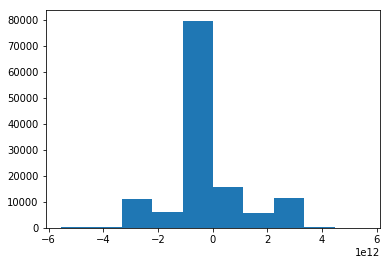

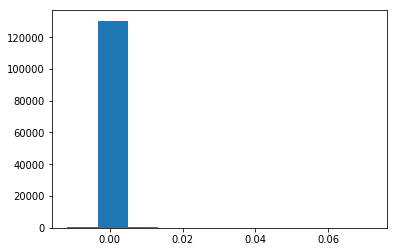

In [44]:
plt.hist(ols.coef_[0])
plt.show()

plt.hist(rdg.coef_[0])
plt.show()

### ROC plot to compare performance of various models and fits

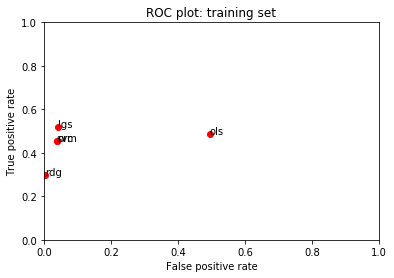

In [45]:
#fits = [svm_performance, lgs_performance, nbs_performance, rdg_performance, prc_performance]
fits = [svm_performance, lgs_performance, rdg_performance, prc_performance, ols_performance]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'ro')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: training set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

## a digression: looking inside the `rdg` object

[documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifier.html)

In [26]:
dir(rdg)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_decision_function',
 '_estimator_type',
 '_get_param_names',
 '_label_binarizer',
 '_predict_proba_lr',
 '_preprocess_data',
 '_set_intercept',
 'alpha',
 'class_weight',
 'classes_',
 'coef_',
 'copy_X',
 'decision_function',
 'fit',
 'fit_intercept',
 'get_params',
 'intercept_',
 'max_iter',
 'n_iter_',
 'normalize',
 'predict',
 'random_state',
 'score',
 'set_params',
 'solver',
 'tol']

In [27]:
rdg.get_params()

{'alpha': 1.0,
 'class_weight': None,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'normalize': False,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.001}

In [28]:
type(rdg.coef_)

numpy.ndarray

In [29]:
rdg.coef_.shape

(1, 131074)

In [30]:
print(rdg.coef_[0])

[-3.54960958e-04  0.00000000e+00  0.00000000e+00 ... -9.53809262e-05
  1.01323875e-03  7.18498739e-02]


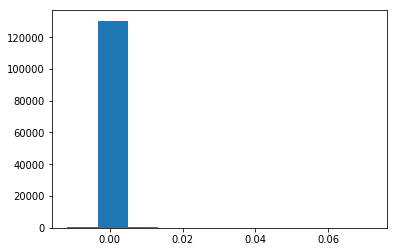

In [31]:
plt.hist(rdg.coef_[0])
plt.show()